In [4]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Flatten, Dense, Dropout, Conv2D, MaxPooling2D, Input,BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [1]:
# Define directories
train_dir = 'chest_xray/train'
test_dir = 'chest_xray/test'

# Image dimensions
img_width, img_height = 100, 100
batch_size = 32
epochs = 20

In [5]:
# Data augmentation and preprocessing for training and validation
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2  # Split data into training and validation sets
)

# Data preprocessing for test data
test_datagen = ImageDataGenerator(
    rescale=1.0/255,
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',  # Use grayscale images
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',  # Use grayscale images
    class_mode='binary',
    subset='validation',
    shuffle=True  # Important for evaluation metrics
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode='grayscale',  # Use grayscale images
    class_mode='binary',
    shuffle=False  # Important for evaluation metrics
)

Found 6400 images belonging to 2 classes.
Found 1600 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [33]:
# Define LeNet-5 model architecture
def build_lenet5(input_shape):
    model = tf.keras.Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),  # Adding dropout layer
        Dense(256, activation='relu'),
        Dropout(0.5),  # Adding dropout layer
        Dense(64, activation='relu'),
        Dropout(0.5),  # Adding dropout layer
        Dense(1, activation='sigmoid')
    ])

    
    return model

# Build the model
input_shape = (img_width, img_height, 1)  # Grayscale images have 1 channel
model = build_lenet5(input_shape)

In [34]:
    # Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks for early stopping and saving the best model
callbacks = [
    ModelCheckpoint('Net5.keras', monitor='val_loss', save_best_only=True, mode='min'),
    EarlyStopping(monitor='val_loss', patience=5, mode='min', verbose=1)
]
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 98, 98, 32)        320       
                                                                 
 batch_normalization_6 (Bat  (None, 98, 98, 32)        128       
 chNormalization)                                                
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 49, 49, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_12 (Conv2D)          (None, 47, 47, 64)        18496     
                                                                 
 batch_normalization_7 (Bat  (None, 47, 47, 64)        256       
 chNormalization)                                                
                                                      

In [35]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/20
200/200 [==============================] - 143s 699ms/step - loss: 0.3753 - accuracy: 0.8873 - val_loss: 4.7383 - val_accuracy: 0.5000
Epoch 2/20
200/200 [==============================] - 139s 695ms/step - loss: 0.1592 - accuracy: 0.9464 - val_loss: 4.6715 - val_accuracy: 0.5000
Epoch 3/20
200/200 [==============================] - 138s 689ms/step - loss: 0.1169 - accuracy: 0.9584 - val_loss: 0.7785 - val_accuracy: 0.7150
Epoch 4/20
200/200 [==============================] - 138s 689ms/step - loss: 0.0864 - accuracy: 0.9648 - val_loss: 0.1431 - val_accuracy: 0.9488
Epoch 5/20
200/200 [==============================] - 138s 688ms/step - loss: 0.0795 - accuracy: 0.9734 - val_loss: 0.1793 - val_accuracy: 0.9331
Epoch 6/20
200/200 [==============================] - 139s 697ms/step - loss: 0.0700 - accuracy: 0.9770 - val_loss: 0.1331 - val_accuracy: 0.9538
Epoch 7/20
200/200 [==============================] - 139s 696ms/step - loss: 0.0549 - accuracy: 0.9830 - val_loss: 0.1485 -

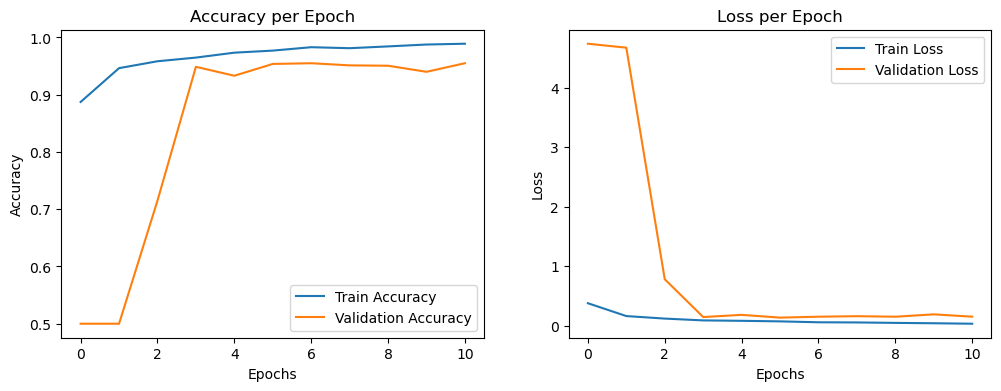

In [36]:
# Plot accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [37]:
# Save the model
model.save('Net5.keras')

In [6]:
# Load the best model
best_model = load_model('Net5.keras')

# Predict on the test set
predictions = best_model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
predictions = (predictions > 0.5).astype(int).reshape(-1)

true_labels = test_generator.classes

print('Confusion Matrix')
print(confusion_matrix(true_labels, predictions))

print('Classification Report')
print(classification_report(true_labels, predictions, target_names=['NORMAL', 'PNEUMONIA']))


20/20 [==============================] - 8s 362ms/step
Confusion Matrix
[[ 60 174]
 [  1 389]]
Classification Report
              precision    recall  f1-score   support

      NORMAL       0.98      0.26      0.41       234
   PNEUMONIA       0.69      1.00      0.82       390

    accuracy                           0.72       624
   macro avg       0.84      0.63      0.61       624
weighted avg       0.80      0.72      0.66       624

